In [ ]:
!pip install easyocr transformers torch
!pip install requests opencv-python
!pip install opencv-python-headless

In [ ]:
!pip install --upgrade git+https://github.com/huggingface/transformers
!pip install accelerate
!pip install timm==1.0.13
!pip install --upgrade accelerate transformers

In [102]:
!pip install langgraph
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 11.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 10.3 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 16.7 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.1 MB/s eta 0:00:00m eta 0:00:010:00:01


In [1]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import TypedDict, Any, Dict, List
import torch
import random
import json
import re

/home/elice/AMA/ocr/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import numpy as np
import unicodedata
import requests 
import easyocr
import requests
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO

In [3]:
import faiss
from sentence_transformers import SentenceTransformer
import os
import pickle

### LangGraph 구성
OCR output → LLM → 요약문 → VectorDB search → 요약문 관련 문제 → LLM → 힌트 생성

In [5]:
# llM 모델 준비
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"

llm_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:53<00:00, 26.86s/it]


In [6]:
# 1. 임베딩 모델 준비
embedding_model = SentenceTransformer("jhgan/ko-sroberta-multitask")

In [54]:
# 검색을 위한 vectorDB와 metadata 불러오기
# AI hub의 "수학 교과 문제 풀이과정 데이터" 중 샘플데이터 400개로 생성된 vectorDB 사용
index = faiss.read_index("faiss_index.idx")
with open("documents.pkl", "rb") as f:
    documents = pickle.load(f)
    texts = [doc["achievement"] for doc in documents]
    metadata_list = [doc["metadata"] for doc in documents]

In [8]:
class AgentState(TypedDict):
    input: str # OCR 출력 text
    summary: str # LLM 요약문
    examples: List[Dict[str, Any]] # 요약문 관련 문제
    hint: str # 문제 힌트

In [9]:
def run_exaone_summary(text: str, max_new_tokens=512) -> str:
    prompt = f"""### Instruction:
다음은 초등학교 교육용 교안입니다. 이 교안의 핵심 내용만 간략하게 요약해주세요. 핵심 개념, 학습 목표 및 핵심 활동 등을 포함하세요.
초등학교 몇학년 몇학기 과정인지도 포함해주세요

### Input:
{text}

### Assistant:
"""

    messages = [
        {"role": "system", 
         "content": "당신은 초등학교 교육자료를 잘 요약해 주는 유능한 AI입니다."},
        {"role": "user", "content": prompt}
    ]

    input_ids = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt"
            )

    output_ids = llm_model.generate(
        input_ids.to("cuda"),
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False,
        )

    # ✅ 여기서 문자열로 디코딩
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # ✅ 문자열에 대해 split 적용
    if "### Assistant:" in output_text:
        result = output_text.split("### Assistant:")[-1].strip()
        print('\n\n', result)
        return result
    
    return output_text.strip()

In [126]:
# 2. 예시 문제 검색 함수
def search_examples_by_summary(summary: str):
    # 정규표현식으로 "학습 목표"부터 "핵심 활동"까지 사이 텍스트 추출
    match = re.search(r"\*\*학습 목표:\*\*(.*?)\*\*핵심 활동:\*\*", summary, re.DOTALL)
    achievement = match.group(1).strip()

    query_vec = embedding_model.encode([achievement], convert_to_numpy=True)
    top_k = 3
    distances, indices = index.search(query_vec, top_k)

    results = []
    for idx in indices[0]:
        results.append({
            "achievement": texts[idx],
            "metadata": metadata_list[idx]
        })

    for result in results:
        print("\n\n📘 성취기준:", result["achievement"])
        meta = result["metadata"]
        print("🏫 학교:", meta["school"], "📚 학년:", meta["grade"], "🧩 난이도:", meta["level_of_difficulty"])
        print("📝 문항:", meta["text_description_by_class"].get("문항", []))
        print("📝 해설:", meta["text_description_by_class"].get("해설", []))
        print("📝 정답:", meta["text_description_by_class"].get("정답", []))
        print("-----")

    return results

In [127]:
def run_exaone_generation(text: str, max_new_tokens=512) -> str: 
    question = text['metadata']['text_description_by_class']['문항']
    explanation = text['metadata']['text_description_by_class']['해설']

    prompt = f"""### 너는 초등학교 수학 교사 역할이야. 아래 문제에 대해 **직접적인 정답을 말하지 않고**, 학생이 스스로 생각해보도록 유도하는 형태로 힌트를 제공해줘.

문제:
{question}

해설:
{explanation}

힌트를 다음 조건에 따라 작성해줘:
1. 학생이 **비율의 의미**와 **밀집도**의 개념을 떠올릴 수 있도록 질문 형태로 유도해줘.
2. 구체적인 숫자를 일부 활용해도 되지만, 최종 정답은 직접 말하지 마.
3. 힌트는 2~3문장 정도의 길이로 구성해줘.
4. 문장은 초등학생이 이해할 수 있도록 **쉬운 표현**을 써줘.

힌트를 출력해줘.
"""
    
    messages = [
        {"role": "system", 
         "content": "당신은 초등학교 수학 문제에 대한 힌트롤 잘 제공해주는 유능한 AI입니다."},
        {"role": "user", "content": prompt}
    ]
    
    input_ids = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt"
            )
    
    output_ids = llm_model.generate(
        input_ids.to("cuda"),
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False,
        )
    
    # ✅ 여기서 문자열로 디코딩
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    # ✅ 문자열에 대해 split 적용
    if "### 힌트:" in output_text:
        result = output_text.split("### 힌트:")[-1].strip()
        print('\n\n📝 힌트:', result)
        return result

    return output_text.strip()

In [128]:
def summarize_node(state: dict) -> dict:
    input_text = state["input"]
    summary = run_exaone_summary(input_text)
    return {"summary": summary}

def example_select_node(state: dict) -> dict:
    summary = state["summary"]
    matched_examples = search_examples_by_summary(summary)
    return {"examples": matched_examples}

def hint_node(state: dict) -> dict:
    example = state["examples"][0]
    hint = run_exaone_generation(example)
    return {"hint": hint}

In [129]:
builder = StateGraph(AgentState)
builder.add_node("summarize", RunnableLambda(summarize_node)) # 원본 문서와 유사도 평가 필요
builder.add_node("search_example", RunnableLambda(example_select_node)) # 문제의 연관성 확인 필요
builder.add_node("make_hint", RunnableLambda(hint_node)) # 각 힌트의 연관성 및 유용성 필요

builder.set_entry_point("summarize")
builder.add_edge("summarize", "search_example")
builder.add_edge("search_example", "make_hint")
builder.add_edge("make_hint", END)

graph = builder.compile()

### OCR

In [130]:
def url_to_image(url):
    # URL에서 이미지 데이터를 받아 OpenCV 이미지로 변환
    resp = requests.get(url)
    image = np.asarray(bytearray(resp.content), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

In [132]:
def EasyOCR_from_url(url):
    img = url_to_image(url)

    # BGR(OpenCV) -> RGB(PIL) 변환
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)

    # 이미지 표시 (Jupyter 환경)
    display(pil_img)

    # 3) EasyOCR reader 생성 (한글+영어)
    reader = easyocr.Reader(['ko', 'en'])

    # 4) 이미지에 OCR 수행
    results = reader.readtext(img)
    
    # 5) 결과 출력
    # for bbox, text, prob in results:
    #     print(f'Text: {text}, Confidence: {prob:.2f}')

    merged_text = " ".join([text for _, text, _ in results])
    return merged_text

In [133]:
def EasyOCR_from_file(file_path, show_image=True):
    # 1) 이미지 로드 (OpenCV는 BGR)
    img_bgr = cv2.imread(file_path)
    if img_bgr is None:
        raise FileNotFoundError(f"이미지를 불러올 수 없습니다: {file_path}")

    # BGR → RGB로 변환 (matplotlib 표시용)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2) EasyOCR reader
    reader = easyocr.Reader(['ko', 'en'])

    # 3) OCR 수행
    results = reader.readtext(img_rgb)

    # 4) 텍스트 병합
    merged_text = " ".join([text for _, text, _ in results])

    # 5) 이미지 출력 (옵션)
    if show_image:
        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()
    
    return merged_text

### TEST

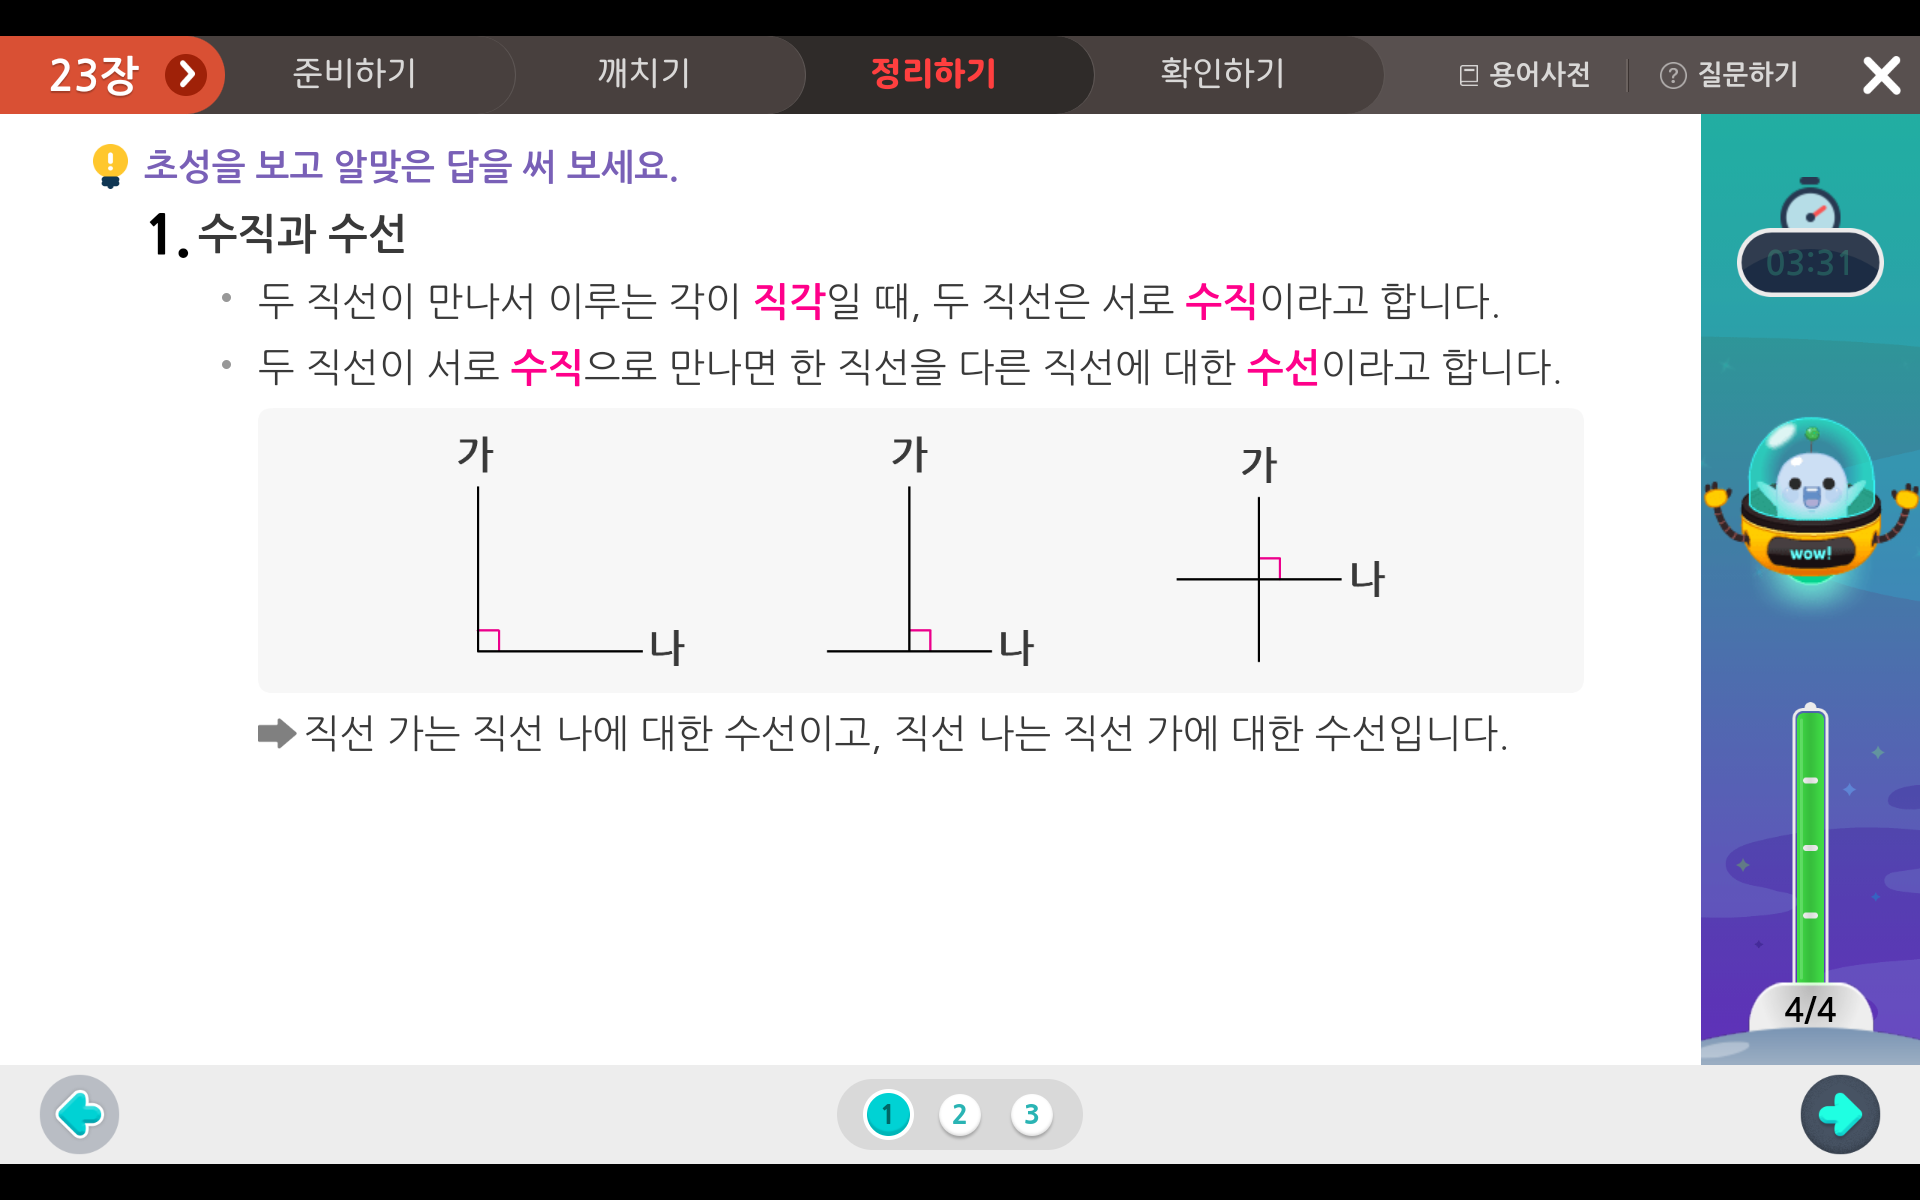

OCR result:  23장 준비하기 깨치기 정리하기 확인하기 용어사전 질문하기 X 초성올 보고 알맞은 답을 씨 보세요. 1.수직과 수선 03831 두 직선이 만나서 이루는 각이 직각일 때 , 두 직선은 서로 수직이라고 합니다. 두 직선이 서로 수직으로 만나면 한 직선올 다른 직선에 대한 수선이라고 합니다. 가 가 가 wowl 나 나 직선 가는 직선 나에 대한 수선이고 직선 나는 직선 가에 대한 수선입니다. 414


 [|assistant|]### 교안 요약

**학년 및 학기:** 초등학교 4학년 2학기  
**주제:** 수직과 수선의 이해

**핵심 개념:**
- **수직선**: 두 직선이 직각(90°)으로 만나는 관계를 설명합니다.
- **수선**: 한 직선이 다른 직선과 만나는 각을 직각으로 만드는 직선입니다. 즉, 한 직선이 다른 직선에 대해 수직인 관계를 의미합니다.

**학습 목표:**
1. 학생들이 두 직선이 직각으로 만나는 경우를 정확히 이해하고 수직선의 개념을 습득합니다.
2. 학생들이 주어진 직선들 간의 수선 관계를 식별하고 설명할 수 있게 합니다.

**핵심 활동:**
- **활동 예시:**
  - **직각 확인 게임**: 학생들이 다양한 각도를 가진 도형을 그려보고, 직각인지 아닌지를 확인하는 활동을 통해 수직선의 개념을 체험적으로 배웁니다.
  - **수선 그리기**: 주어진 직선들에 대해 각각의 수선을 그려보는 실습을 통해 수선의 정의와 성질을 이해합니다.
  - **토론 및 질문 시간**: 학생들이 서로 질문하고 답변하며 개념을 깊이 이해하도록 유도합니다. 예를 들어, "직선 A가 직선 B에 대해 수선일 때, 직선 B는 직선 A에 대해 어떤 각을 이루나요?"와 같은 질문을 통해 개념을 확장합니다.

이 교안은 학생들이 기하학적 관계 중 특히 수직과 수선에 대한 기본적인 이해를 높이는 데 중점을 두고 있습니다.


📘 성취기준: [4수03-01] 직선, 선분, 반직선을 이해하고 구별할 수 있다.
🏫 학교: 초등학교 📚 학년: 3학

In [134]:
url = 'https://www.home-learn.co.kr/common/image.do?imgPath=newsroom&imgName=CK20221226131232394.png&imgGubun=D'
text = EasyOCR_from_url(url)
print("OCR result: ", text)

result = graph.invoke({"input": text})
print("✅ 요약 및 문제 생성 완료!")

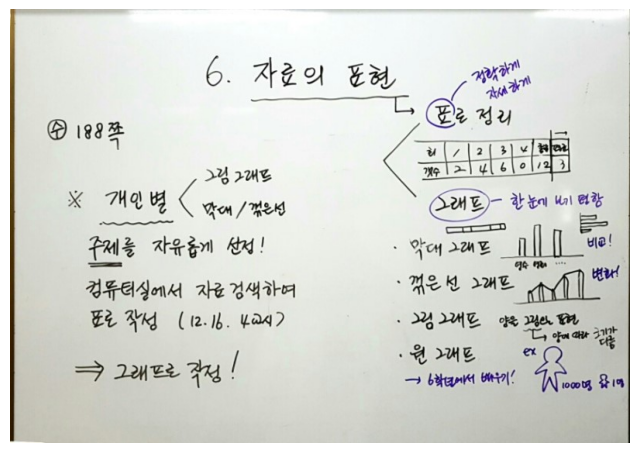

OCR result:  6. 자료의   표현 프로 정리 188쪽 ) 그래드 깊요요lL력] 개우 개인 별 막대 / 꺾은서 그래t 한눈n l기l 터향 클 주제름 자유급끼   선접 ! 막대 그래프 비교! 변화 컴퓨터실예서   자군 경색하여 꺾은 선   그래프 표로 작성 ((2.16. 나i시? 핑부프 양울 끝 #zn 편 값 원 ~드 그래모 6학길서 6무기? looo벼i 819 저락하계 자세하계 극정 !


 [|assistant|]### 교안 요약

**학년 및 학기:**  
- **학년:** 6학년  
- **학기:** 2학기

**핵심 개념:**
- **데이터 표현 방법:** 막대 그래프와 꺾은 선 그래프를 활용한 데이터 시각화
- **정보 해석:** 그래프를 통해 데이터의 변화와 패턴을 이해하기

**학습 목표:**
1. 학생들이 다양한 형태의 그래프 (막대 그래프와 꺾은 선 그래프)를 이해하고 제작할 수 있다.
2. 주어진 데이터를 바탕으로 그래프를 정확하게 작성하고 해석할 수 있는 능력을 키운다.
3. 그래프를 통해 데이터의 추세와 변화를 효과적으로 파악하고 설명할 수 있다.

**핵심 활동:**
- **그래프 제작 실습:** 컴퓨터실에서 막대 그래프와 꺾은 선 그래프를 직접 만들어 보는 활동
- **데이터 분석 토론:** 제작된 그래프를 바탕으로 데이터의 의미와 변화를 토론하고 발표하기
- **비교 분석 과제:** 두 가지 다른 주제의 데이터를 비교하는 그래프를 작성하고 그 결과를 분석하는 프로젝트 수행

이 교안은 학생들이 실제 데이터를 시각적으로 표현하고 이해하는 능력을 향상시키는 데 중점을 두고 있습니다.


📘 성취기준: [6수03-14] 평행사변형, 삼각형, 사다리꼴, 마름모의 넓이를 구하는 방법을 다양하게 추론하고, 이와 관련된 문제를 해결할 수 있다.
🏫 학교: 초등학교 📚 학년: 5학년 🧩 난이도: 하
📝 문항: ['넓이가 다른 평행사변형은 어느 것인지 기호를 써 보세요.']
📝 해설: ['높이가 같으나 밑변의 길이가 다른 평행사변형은 넓이가

In [135]:
path = 'Office_Lens_20161216-122020.jpg'
text = EasyOCR_from_file(path)
print("OCR result: ", text)

result = graph.invoke({"input": text})
print("✅ 요약 및 문제 생성 완료!")

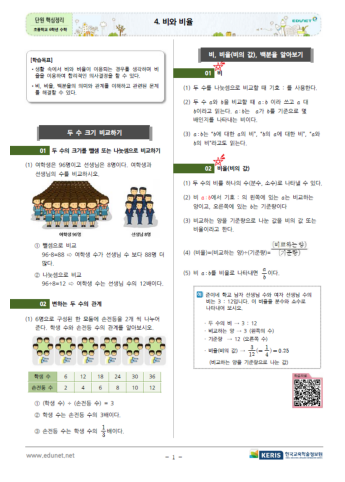

OCR result:  단민 핵심점리 비와 비율 obn레 충륭하고 @바싹 수바 비 비율(비의 값) , 박분율 알아보기 [하습무표] 속예서 키도- 티율미 이용되는 검우 = 생각하더 울올 이용하여 입리직인 의사결침올 합 수 있다 비율; 백문물의 의미되 관계들 이룩하고 관련본 문제 (1) 누 스른 나늦심으로 비고할 때 기드 ' 틀 사용하다. = 하기} 수 있다 (2) 누 스 @와 6올 비고츠 규:0 이리 쓰고 6이라고 읽논다. a :6논 @가 [틀 기준으로 버인지루 나타내느 비이다. 두 수 크기 비교하기 4:6논 '6어 대한 @의 비: '6의 @에 대한 비' '@와 6의 비라고도 익논다. 두 수의 크기름 깔셈 또는 나늦셈으로 비고하기 (1) 여학생온 96명이고 선상님온 8명이다. 여학생과 비율(비의 값) 손생님의 스른 비고하시오 (1) 누 스의 비름 하나의 스수 소스로 나타t 수 있다. 비 4 :6어서 기호  의 왼쪽에 있논 @논 비교하논 양이고 오는쪽어 있드 b논 기준랗이다 비고하는 양울 기준량으로 나는 값율 비익 값 또는 비율이리고 하다. 여학생 95 댐 신빵  6명 벌심으로 비고 (티교하는말) 96-9-88 여학생 스가 선생님 보다 88명 (비율)= (비고하는 양)수(기준량) = [기르로) 많다 나늦심으로 비고 비 &:틀 비율로 나타내련 이다. 96+8=12 여학생 스는 선생님 스의 12배이디. 굳미니 :교 c자 신생님 수퍼 여자 신생님 수미 변하논 두 수의 관계 비는 129니다: 이 비율올 분수와 소수로 나타나미 보시모 (1) 6검으로 구성된 한 드는어 손전등올 2개 씩 나누어 두 수미 티 ' 3 ; 12 준다. 학생 수와 손전등 수의 관계름 알이보시오 비고하는 약 (리꾸의 수) 기준담 12 (으른쪽 수) 티= (리미 값) 흙(= =) = 0-35 (비고하는 양울 기준람으로 나뇨 값) 라생 수 스 -리' 손전= (학생 수) = (손전등 수) = 3 어생 수는 손전등 수의 3배이다. 손전등 수는 학생 수의 슬내이다: Wnirsr edunet net KERIS)

In [136]:
path = 'ratio.png'
text = EasyOCR_from_file(path)
print("OCR result: ", text)

result = graph.invoke({"input": text})
print("✅ 요약 및 문제 생성 완료!")

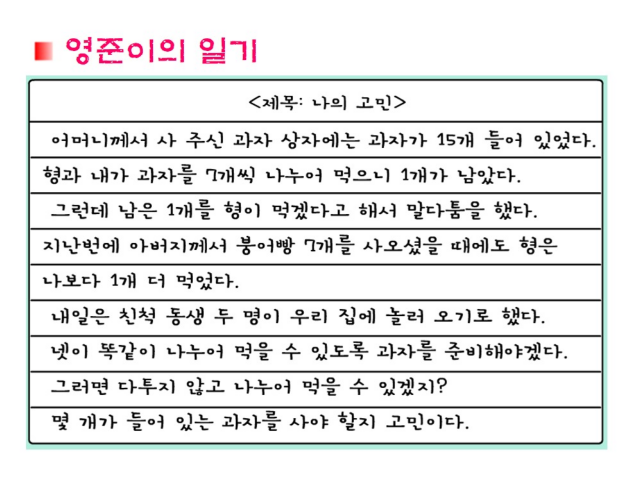

OCR result:  영준이의 일기 <제목: 나의 고민> 어머니께서 사 주신 과자 상자에는 과자가 15개 들어 있있다. 형과 내가 과자틀 7개씩 나누어 먹으니 1개가 남앗다. 그런데 남은 1개틀 형이 먹젯다고 해서 말다툼올 햇다. 지난번에 아버지께서 봉어빵 [개틀 사오여올 때에도 형은 나보다 1개 더 먹없다. 내일은 친척 동생 두 명이 우리 집에 놀러 오기로 햇다. 넷이 똑같이 나누어 먹울 수 엿도록 과자틀 준비해야켓다. 그러면 다투지 암고 나누어 먹울 수 잇젠지? 몇 개가 들어 잇는 과자틀 사야 할지 고민이다.


 [|assistant|]### 교안 요약: 초등학교 3학년 2학기 과정

**학년 및 학기:** 초등학교 3학년 2학기

**핵심 개념:**
- **분수 이해:** 과자 분배 과정에서 남은 과자와 전체 과자 간의 관계를 분수로 표현하기.
- **공정한 분배:** 공평하게 물건을 나누는 방법과 갈등 해결 기술.

**학습 목표:**
1. 학생들이 분수 개념을 통해 과자 분배 상황을 이해하고 계산할 수 있다.
2. 갈등 상황에서 서로의 입장 이해와 타협점 찾는 능력을 키운다.
3. 공평한 분배 방법을 통해 협동심을 기르고 문제 해결 능력을 향상시킨다.

**핵심 활동:**
1. **분수 계산 연습:**
   - 현재 상황에서 남은 과자 1개를 포함한 전체 과자 수를 계산하고, 이를 분수로 표현한다 (예: \( \frac{15}{7} \)).
   - 학생들이 직접 과자 개수를 세어보며 분수 이해를 돕는 활동을 진행한다.

2. **갈등 해결 토론:**
   - 영준이의 일기 내용을 바탕으로 그룹 토론을 통해 각자의 입장과 감정을 공유한다.
   - 공평한 분배 방법을 찾기 위한 아이디어를 제시하고 토론한다 (예: 과자 개수를 늘려 공평하게 나누기).

3. **실제 분배 시뮬레이션:**
   - 학생들이 직접 과자를 나누어 먹는 시뮬레이션을 통해 실제 상황에서의 분배 방법을 경험한다.
   - 친척 동생들이 방문했을 때의 상황을 가정하고, 필요한 

In [137]:
path = 'edu_image.JPG'
text = EasyOCR_from_file(path)
print("OCR result: ", text)

result = graph.invoke({"input": text})
print("✅ 요약 및 문제 생성 완료!")

### VectorDB 생성

In [ ]:
import zipfile
import os

# 압축 파일 경로와 압축 해제 경로 지정
zip_path = "Sample (2).zip"
extract_to = "dataset"

# 압축 해제할 폴더가 없으면 생성
os.makedirs(extract_to, exist_ok=True)

# 압축 풀기
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("압축이 성공적으로 풀렸습니다.")

In [39]:
def collect_json_files(root_dir):
    json_paths = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".json"):
                json_paths.append(os.path.join(root, file))
    return json_paths

In [40]:
def should_include(data):
    for item in data.get("learning_data_info", []):
        if item["class_name"] == "문항(텍스트)":
            for cls in item.get("class_info_list", []):
                text = cls.get("text_description", "")
                if "그림" in text or "이미지" in text:
                    return False
    return True

In [51]:
def extract_documents(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if not should_include(data):
        return []

    doc_texts = data.get("source_data_info", {}).get("2022_achievement_standard", [])
    documents = []

    for std_text in doc_texts:
        metadata = {
            "school": data["raw_data_info"]["school"],
            "grade": data["raw_data_info"]["grade"],
            "semester": data["raw_data_info"]["semester"],
            "level_of_difficulty": data["source_data_info"].get("level_of_difficulty", ""),
            "text_description_by_class": {
                item["class_name"]: [
                    cls.get("text_description", "") for cls in item.get("class_info_list", [])
                ]
                for item in data.get("learning_data_info", [])
            }
        }
        # 조건에 따라 데이터 병합
        metadata["text_description_by_class"] = {
            "문항": metadata["text_description_by_class"].get("문항(텍스트)", []),
            "해설": metadata["text_description_by_class"].get("해설(텍스트)", []) or metadata["text_description_by_class"].get("해설(이미지)", []),
            "정답": metadata["text_description_by_class"].get("정답(텍스트)", []) or metadata["text_description_by_class"].get("정답(이미지)", []),
        }

        documents.append({"achievement": std_text, "metadata": metadata})

    return documents

In [52]:
# 3. 데이터 수집
root_dir = "/home/elice/AMA/ocr/dataset/Sample/02.라벨링데이터"
json_paths = collect_json_files(root_dir)

documents = []
for path in json_paths:
    documents.extend(extract_documents(path))

# 4. 임베딩 및 인덱싱
texts = [doc["achievement"] for doc in documents]
embeddings = embedding_model.encode(texts, convert_to_numpy=True)

dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

# 5. 인덱스 및 메타데이터 저장
faiss.write_index(index, "faiss_index.idx")
with open("documents.pkl", "wb") as f:
    pickle.dump(documents, f)